# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
- `datasets/geo_data_0.csv`
- `datasets/geo_data_1.csv`
- `datasets/geo_data_2.csv`

Признаки, содержащиеся в датасетах:
- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
!pip install scikit-learn==1.5.0

In [2]:
!pip install phik -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

import phik
import sklearn

In [4]:
RANDOM_STATE = 42
TEST_SIZE =0.25

In [5]:
POINTS = 500 
BEST_POINTS = 200 
MONEY = 10000000000
PRICE = 450000 

In [6]:
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Проекты спринтов\2 Машинное обучение в бизнесе\geo_data_0.csv") 
    geo_data_1 = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Проекты спринтов\2 Машинное обучение в бизнесе\geo_data_1.csv")
    geo_data_2 = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Проекты спринтов\2 Машинное обучение в бизнесе\geo_data_2.csv")
 

In [7]:
def info (df):
    print (df.info())
    display (df.describe())

In [8]:
info (geo_data_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
info (geo_data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
info (geo_data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Проверим пропуски и явные дубликаты

In [11]:
def isna(df):
    number_isna = df.isna().sum().sum()
    number_duplicated = df.duplicated().sum().sum()
    if (number_isna > 0) or (number_duplicated > 0):
        print (f'Количество пропусков составляет  {number_isna}, количество дубликатов составляет {number_duplicated}')
    else:
        print ('Пропусков и явных дубликатов не обнаружено')

In [12]:
isna(geo_data_0)

Пропусков и явных дубликатов не обнаружено


In [13]:
isna(geo_data_1)

Пропусков и явных дубликатов не обнаружено


In [14]:
isna(geo_data_2)

Пропусков и явных дубликатов не обнаружено


Изучим данные на предмет неявных дублей.

In [15]:
dict_data = {'geo_data_0':geo_data_0, 'geo_data_1': geo_data_1, 'geo_data_2': geo_data_2}

In [16]:
for name, df in dict_data.items():
    for k in df.columns.to_list():
        if df[k].duplicated().sum() > 0:
            print (f'Обнаружены дубликаты в столбце {k} датафрейма {name} в количестве {df[k].duplicated().sum()}')

Обнаружены дубликаты в столбце id датафрейма geo_data_0 в количестве 10
Обнаружены дубликаты в столбце id датафрейма geo_data_1 в количестве 4
Обнаружены дубликаты в столбце product датафрейма geo_data_1 в количестве 99988
Обнаружены дубликаты в столбце id датафрейма geo_data_2 в количестве 4


In [17]:
list_id = geo_data_0[geo_data_0['id'].duplicated()]['id'].to_list()

In [18]:
for i in list_id:
    display (geo_data_0[geo_data_0['id'] ==i])

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


,id,f0,f1,f2,product
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


В дубликатах по `id` значения признаков отличаются. Однозначно судить о причинах дубликатов невозможно, к счастью их количество невелико:
- для geo_data_0 - 10 из 100 тыс., что составляет 0,01%. 
- для geo_data_1 - 4 из 100 тыс., что составляет 0,004%
- для geo_data_2 - 4 из 100 тыс., что составляет 0,004%

*Удалим дубликаты*

In [19]:
geo_data_0 = geo_data_0.drop_duplicates('id').reset_index(drop=True)
geo_data_1 = geo_data_1.drop_duplicates('id').reset_index(drop=True)
geo_data_2 = geo_data_2.drop_duplicates('id').reset_index(drop=True)

Проверим размерность

In [20]:
print(geo_data_0.shape)
print(geo_data_1.shape)
print(geo_data_2.shape)

(99990, 5)
(99996, 5)
(99996, 5)


Размеремся с дубликатами в `product` geo_data_1.

In [21]:
list_dubl_product = geo_data_1[geo_data_1['product'].duplicated()]['product'].to_list()

In [22]:
geo_data_1[geo_data_1['product'].duplicated()]['product'].sort_values().unique()

array([  0.        ,   3.17910258,  26.95326103,  30.13236361,
        53.90652206,  57.08562465,  80.85978309,  84.03888568,
       107.81304413, 110.99214671, 134.76630516, 137.94540774])

In [23]:
geo_data_1['product'].sort_values().unique()

array([  0.        ,   3.17910258,  26.95326103,  30.13236361,
        53.90652206,  57.08562465,  80.85978309,  84.03888568,
       107.81304413, 110.99214671, 134.76630516, 137.94540774])

Все значения в столбце `product` geo_data_1 похожи на категориальные. Цифры повторяются и всего имеется 12 величин значений. С этими дубликатами сделать ничего не получится оставим как есть.

**Промежуточный вывод:**
1. Проведена загрузка данных и ознакомление с ними. Все три датафрейма состоят из 100 тыс. значений.
2. Названия столбцов соответствуют стандарту (змеиный регистр и латиница).
3. Типы данных соответствуют.
4. Удалены неявные дубликаты.
5. Пропусков не обнаружено.

### Исследовательский анализ.

In [24]:
#geo_data_0 = geo_data_0.set_index('id')
#geo_data_1 = geo_data_1.set_index('id')
#geo_data_2 = geo_data_2.set_index('id')

In [25]:
def hist_plot(df):
    df= df.set_index('id')
    for i in df.columns.to_list():
        plt.figure(figsize=(20,10))
        
        plt.subplot(1,2,1)
        sns.histplot(data=df, x=i, bins = 50)
        plt.ylabel('Количество значений')
        plt.xlabel(f'{i}')
        plt.title('Гистограмма')
                     
        plt.subplot(1,2,2)
        sns.boxplot(data=df, x=i)
        plt.xlabel(f'{i}')
        plt.title('Боксплот')
        
        plt.suptitle(f'Гистограмма и боксплот для {i}')

Посмотрим на графики.

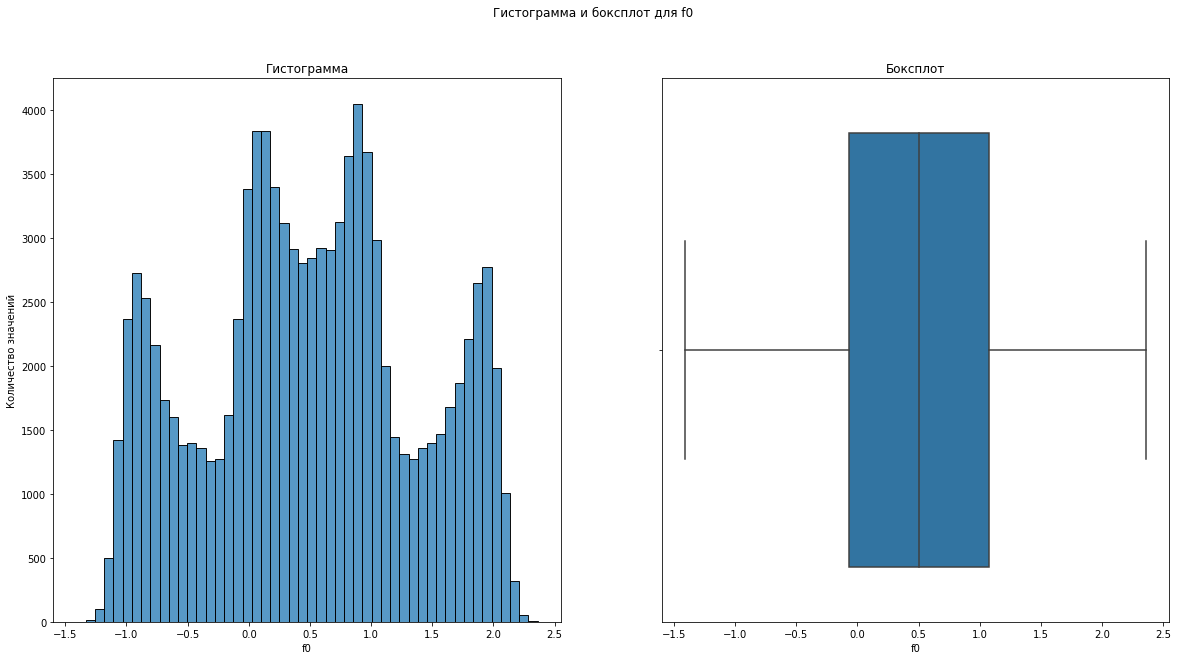

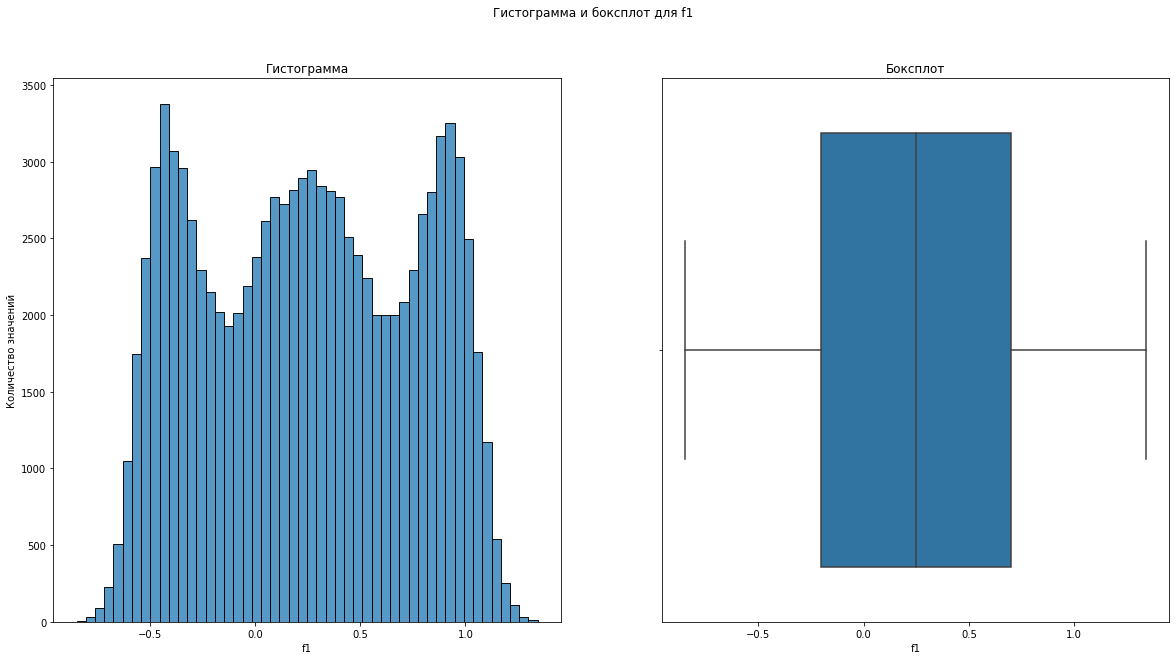

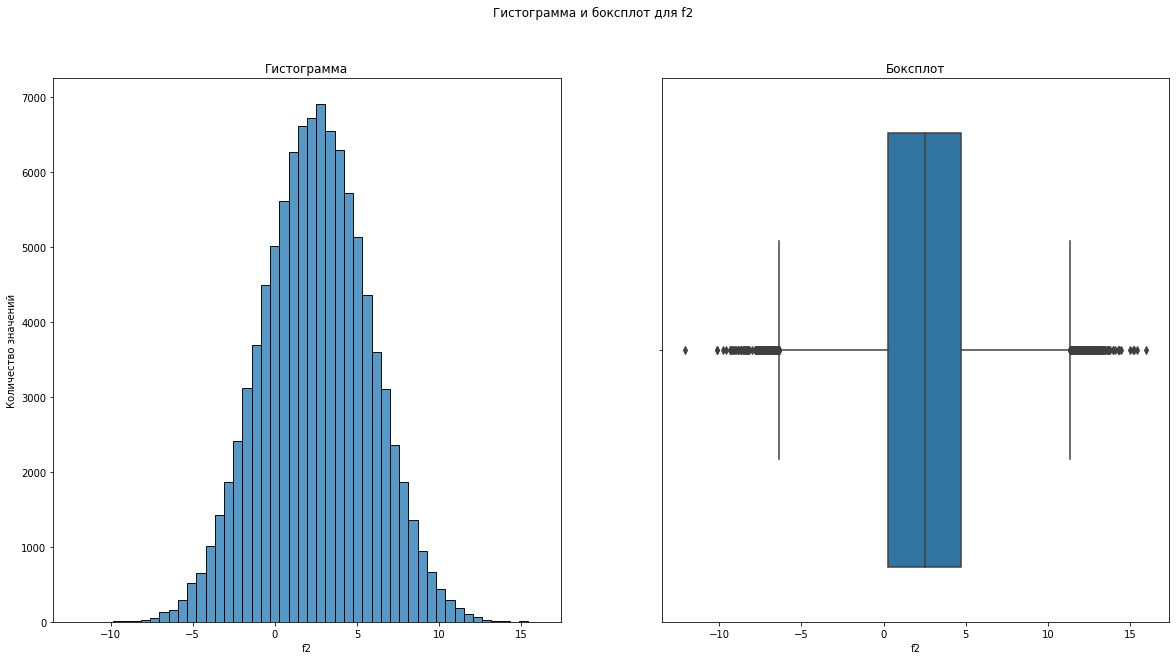

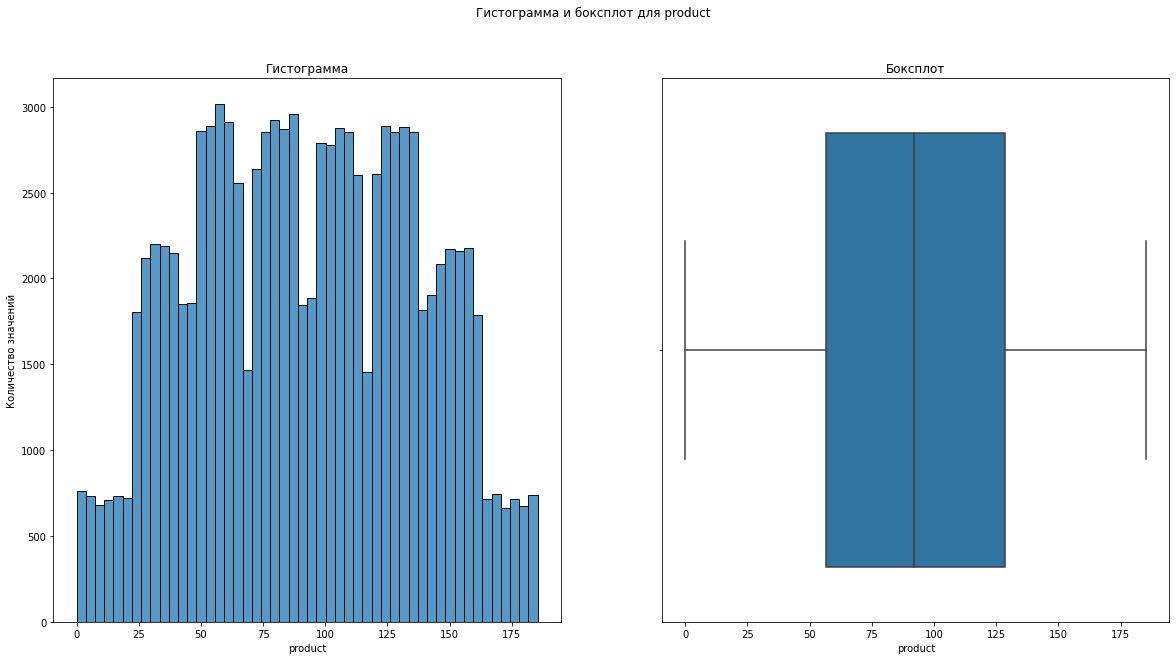

In [26]:
hist_plot(geo_data_0)

**Анализ для geo_data_0:**
1. параметр f0:
    - в распределении значений имеется 4 вершины. 
    - выбросов нет.
2. параметр f1:
    - в распределении значений имеется 3 вершины. 
    - выбросов нет.
3. параметр f2:
    - имеет нормальное распределение. 
    - имеются выбросы.
4. параметр product:
    - нет нормального распределения. 
    - выбросов нет.

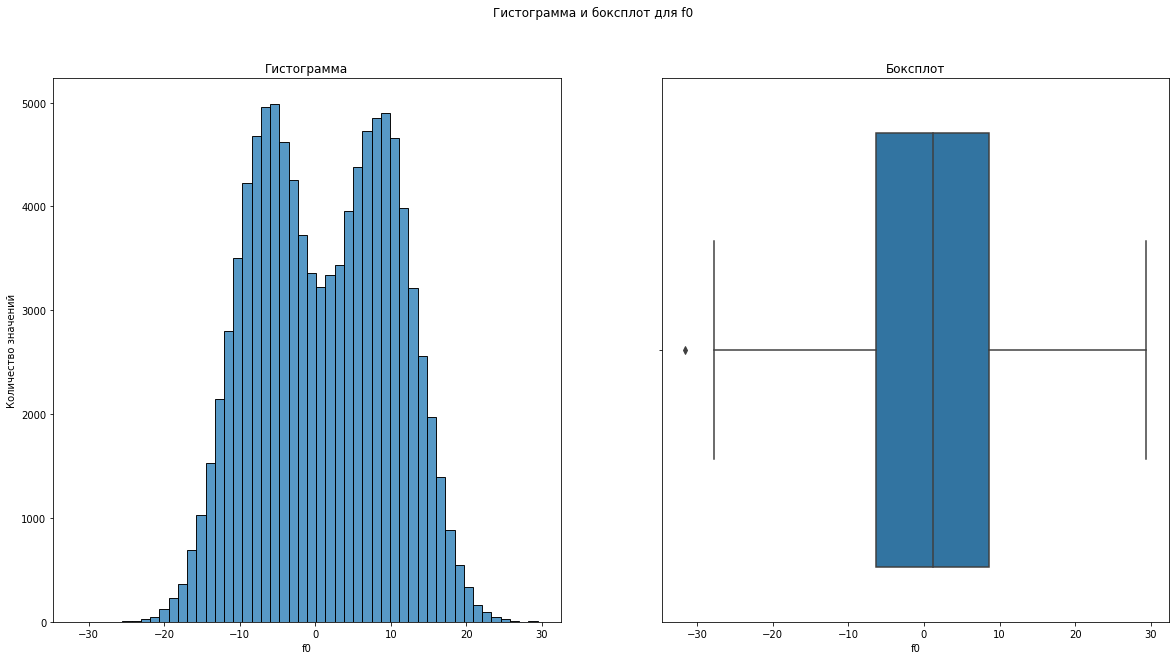

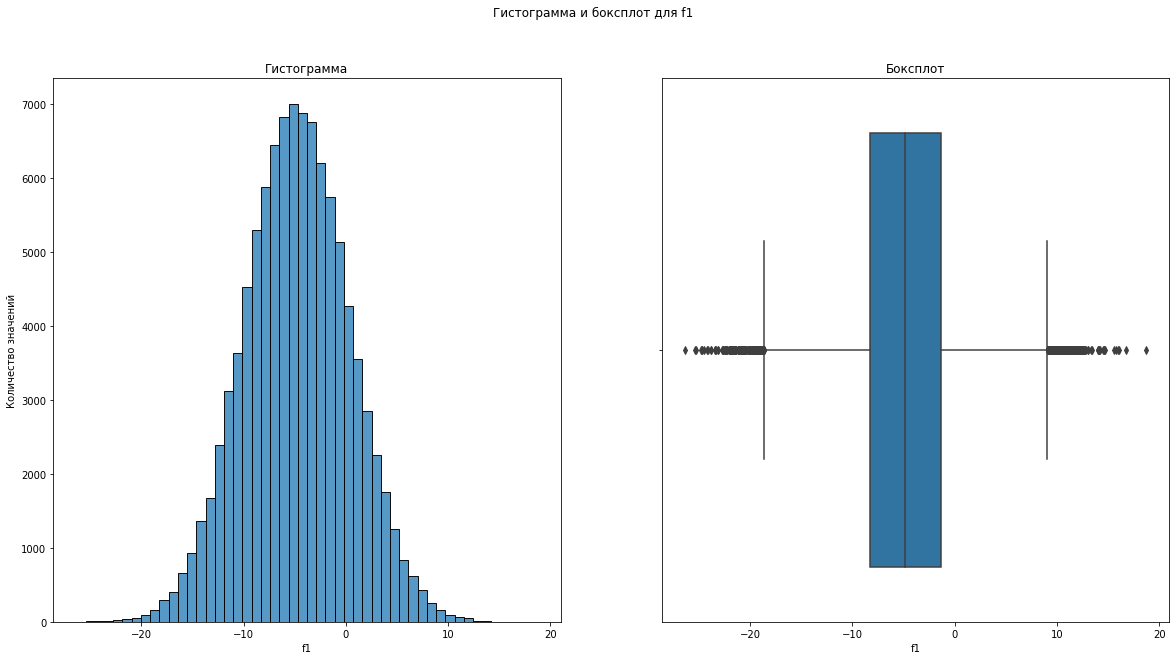

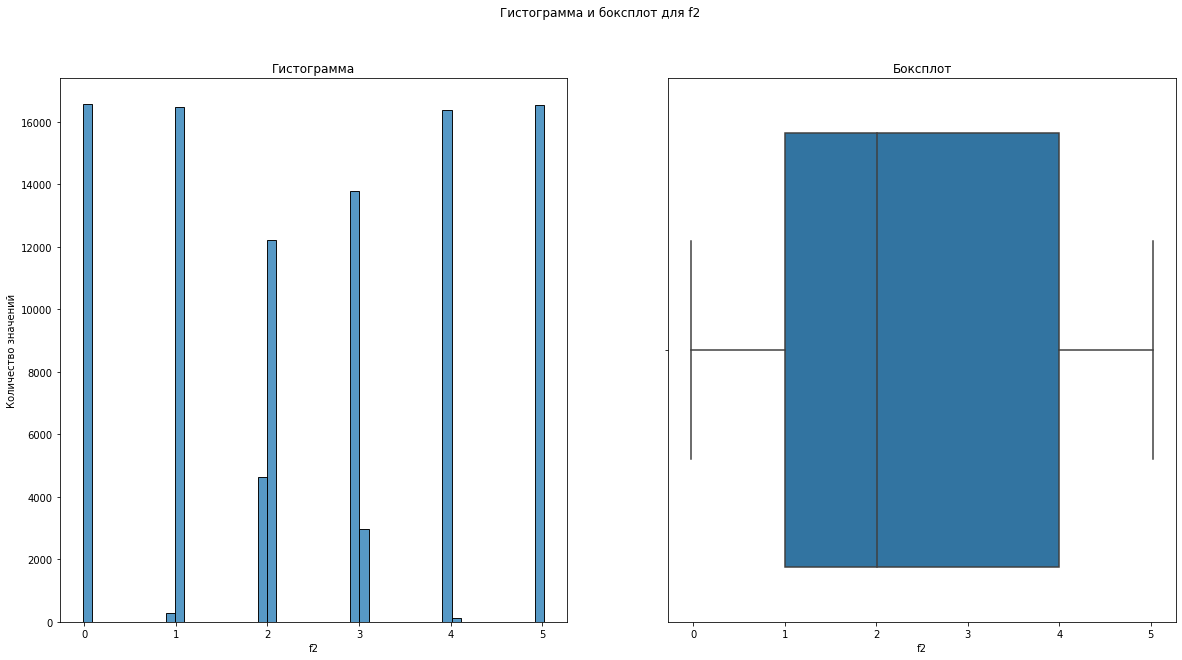

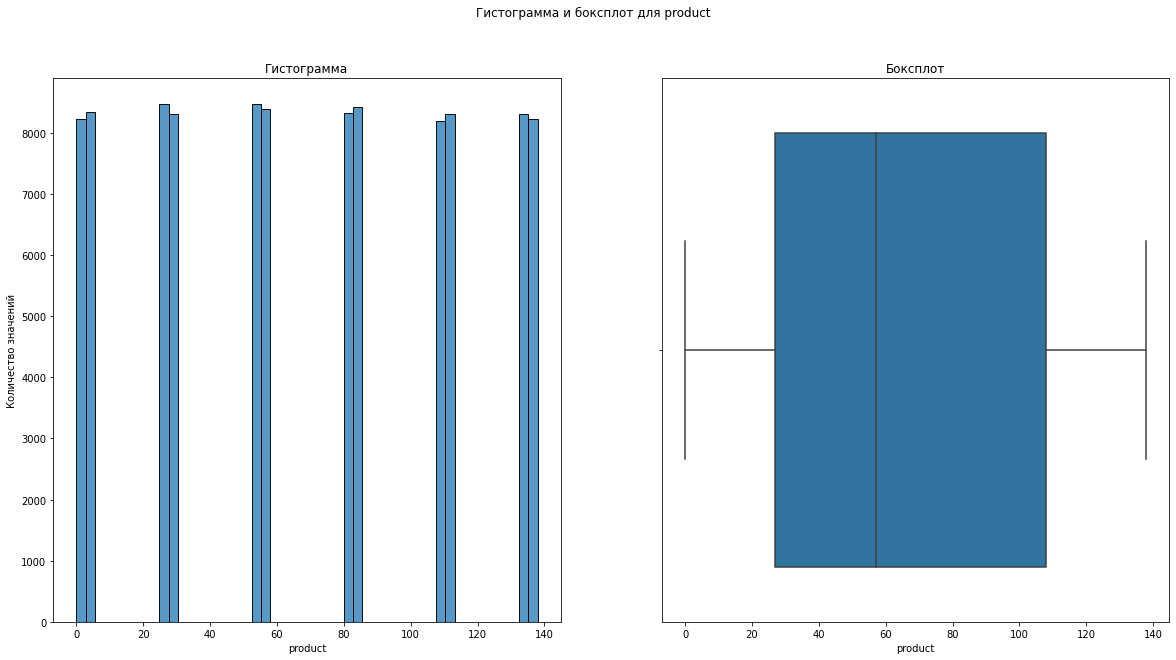

In [27]:
hist_plot(geo_data_1)

**Анализ для geo_data_1:**
1. параметр f0:
    - в распределении значений имеется 2 вершины. 
    - имеется 1 значение выброса.
2. параметр f1:
    - имеет нормальное распределение. 
    - имеются выбросы.
3. параметр f2:
    - данные не являются непрерывными. 
    - выбросов нет.
4. параметр product:
    - данные не являются непрерывными. 
    - выбросов нет.

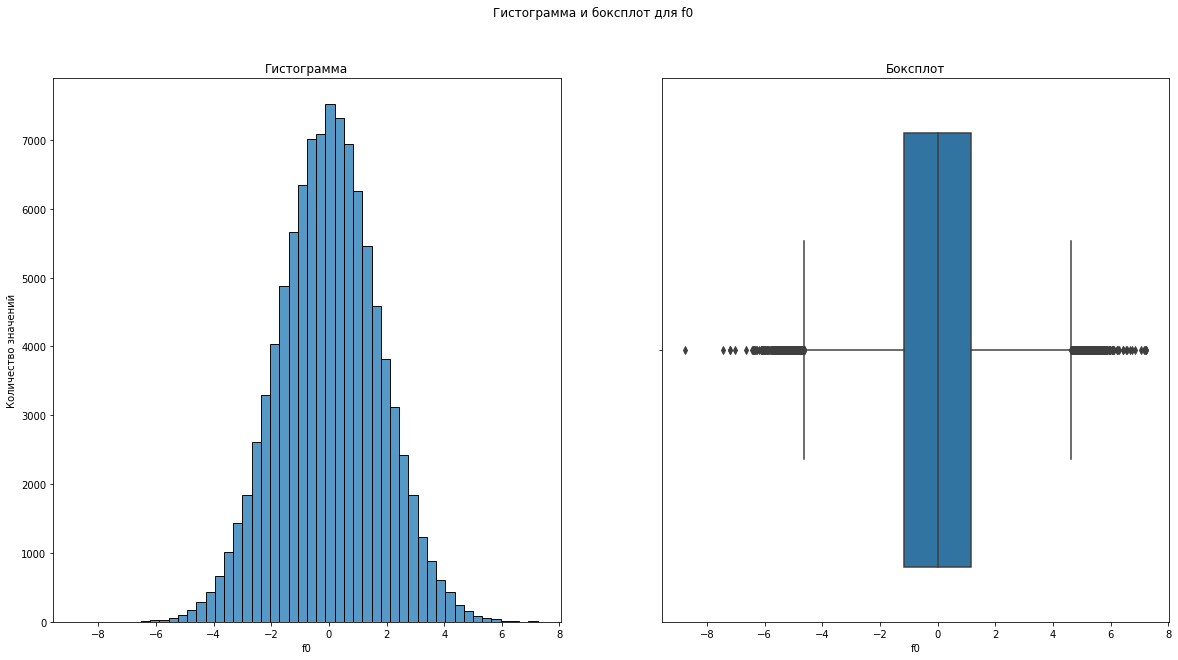

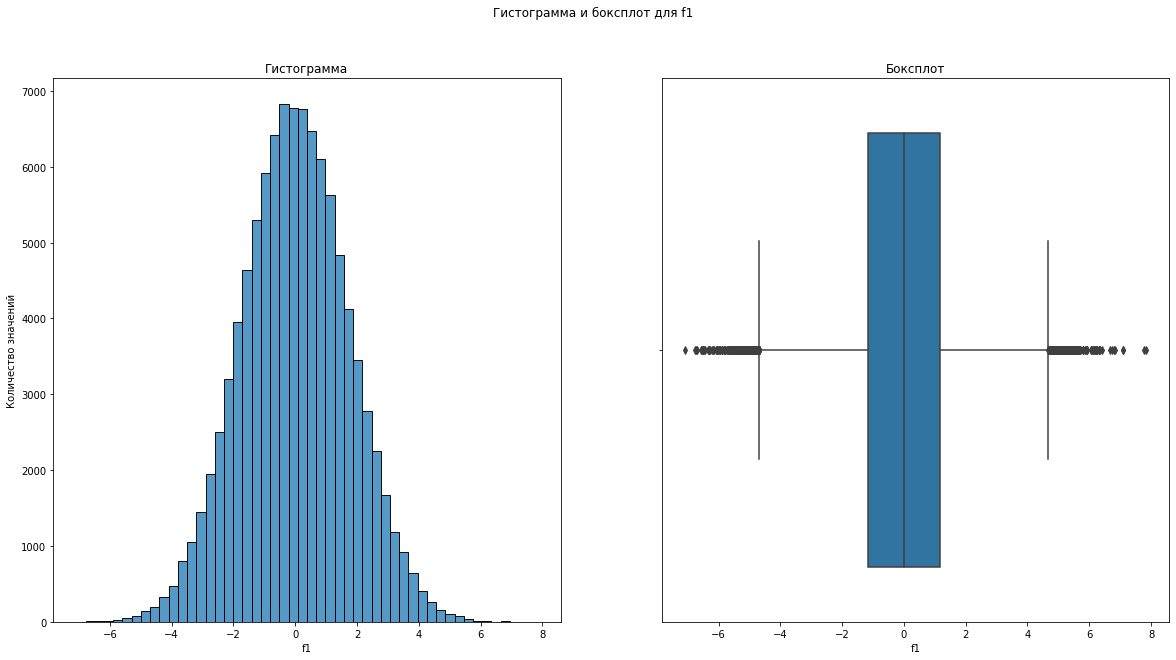

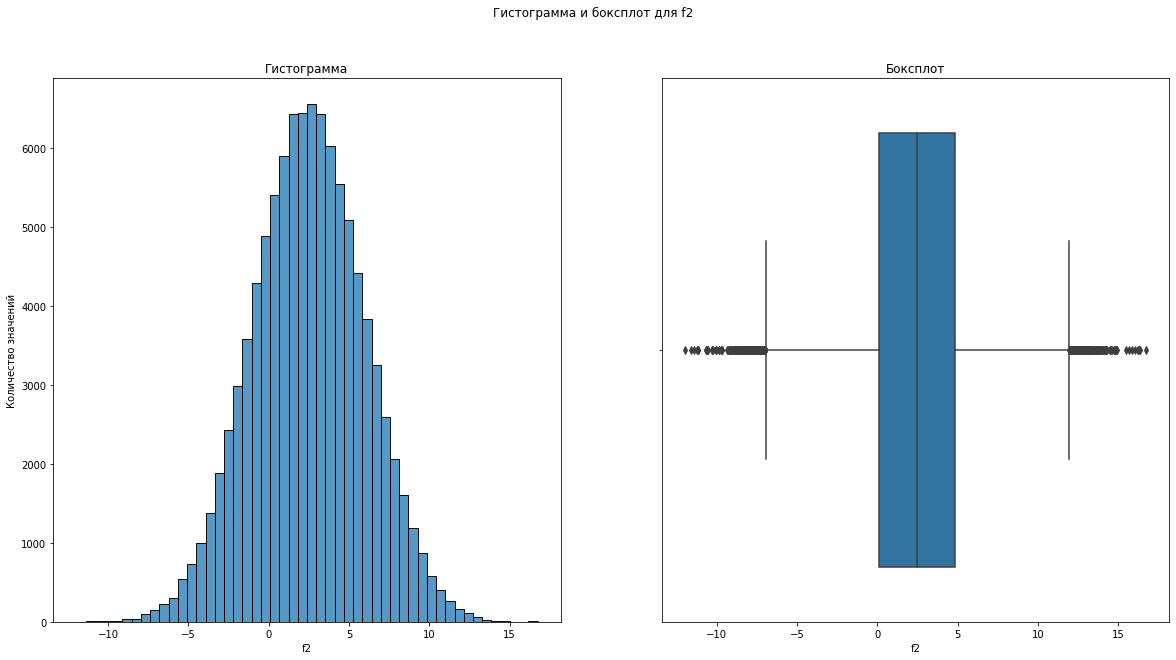

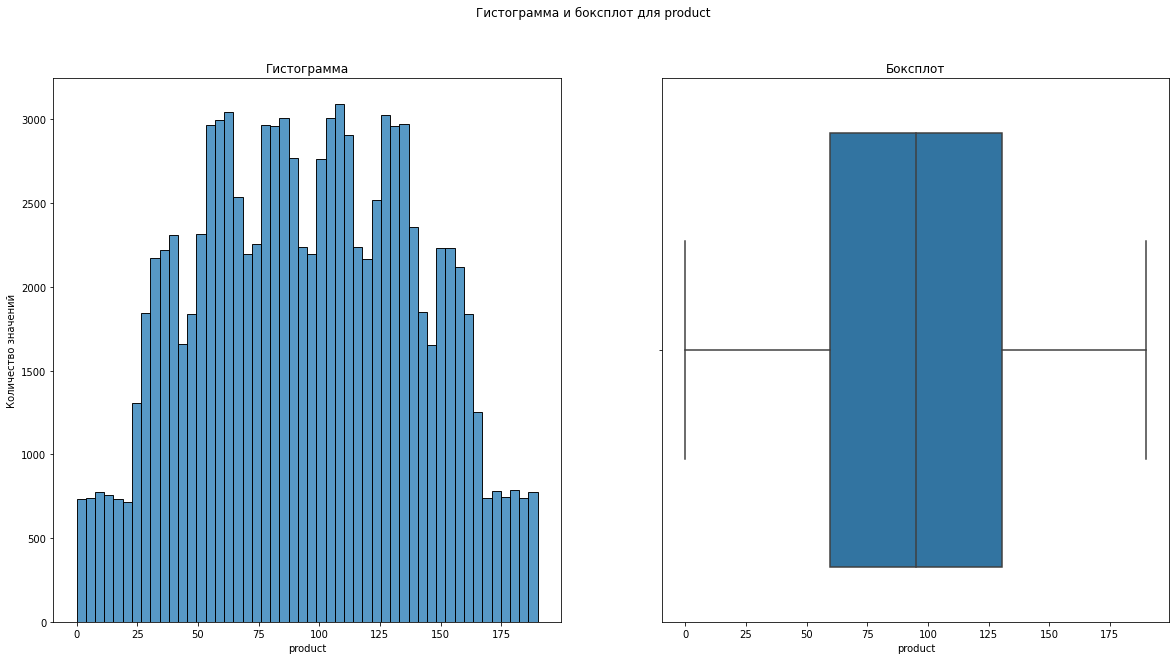

In [28]:
hist_plot(geo_data_2)

**Анализ для geo_data_2:**
1. параметр f0:
    - имеет нормальное распределение. 
    - имеются выбросы.
2. параметр f1:
    - имеет нормальное распределение. 
    - имеются выбросы.
3. параметр f2:
    - имеет нормальное распределение. 
    - имеются выбросы.
4. параметр product:
    - Данные не имеют нормального распределения. 
    - выбросов нет.

**Промежуточный вывод**
1. Проведен исследовательский анализ. Составлены графики.
2. В данных есть выбросы, однако неизвестна их природа.
3. В geo_data_2 входные признаки распределны нормально.
4. В geo_data_1 входной признак f2 похож на категориальный.

### Корреляционный анализ данных

In [29]:
def heatmap(df):
    df=df.set_index('id')
    corr_matrix = df.phik_matrix(interval_cols = df.columns.to_list())
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
    plt.title(f'Тепловой график корреляции признаков')


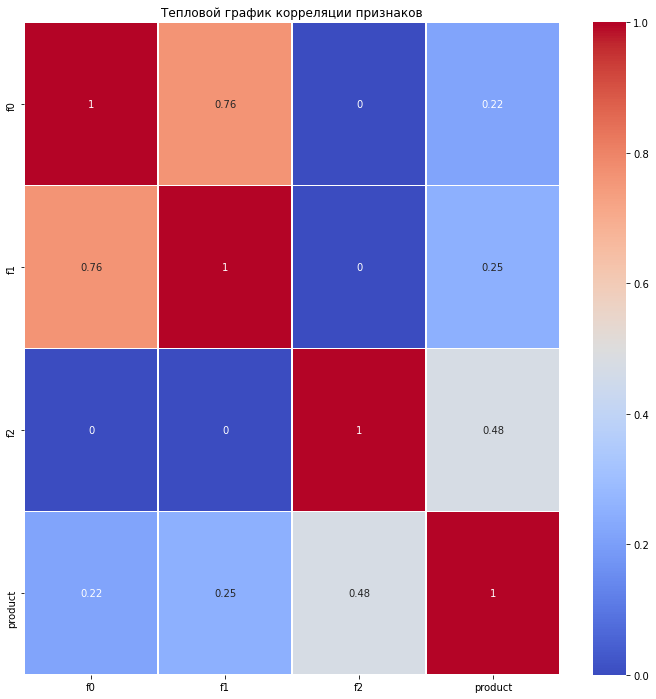

In [30]:
heatmap(geo_data_0)

Text(0.5, 1.0, 'График точечной зависимости f1 и f0')

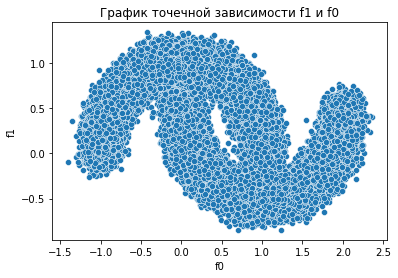

In [31]:
sns.scatterplot(data = geo_data_0, x='f0', y='f1')
plt.title('График точечной зависимости f1 и f0')

Зависимость f1 и f0 нелинейная.

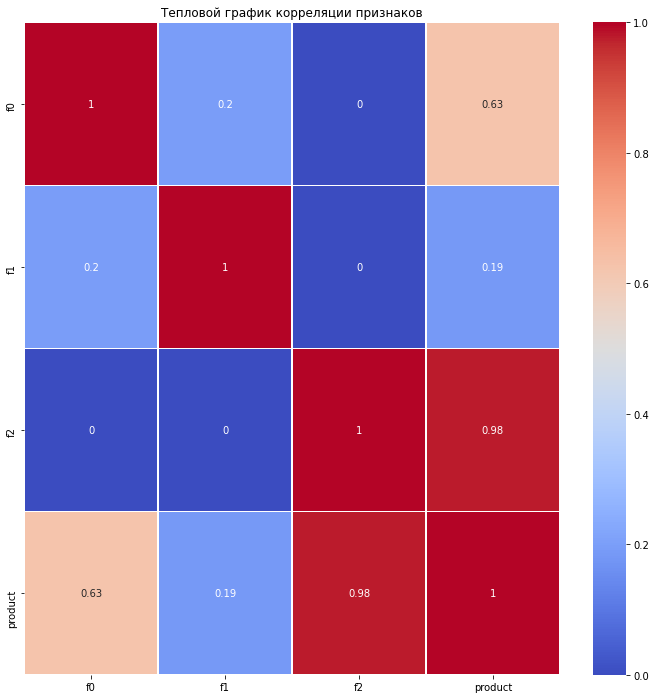

In [32]:
heatmap(geo_data_1)

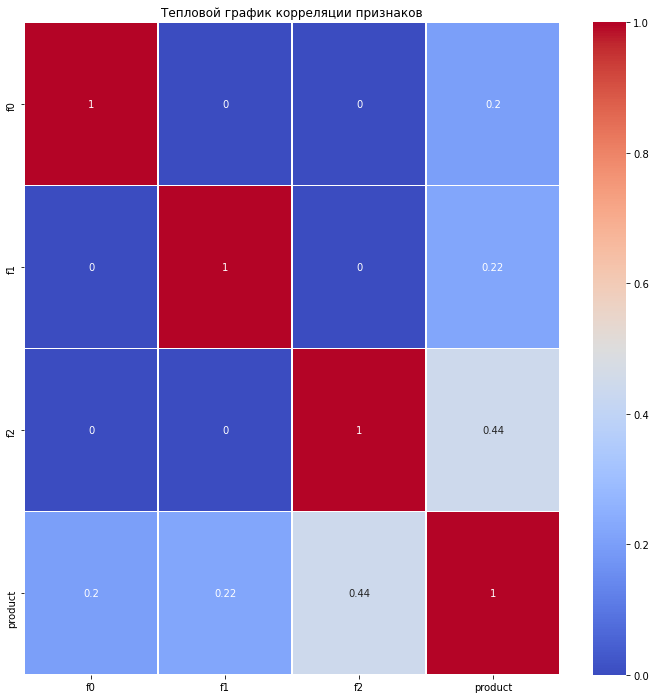

In [33]:
heatmap(geo_data_2)

**Промежуточный вывод по корреляционному анализу:**
1. Для geo_data_0:
    - есть нелинейная корреляция между f0 и f1
2. Для geo_data_1:
    - есть корреляция между f2 и product. Хорошая зависимость f2 с целевым признаком 
3. Для geo_data_2:
    - есть корреляция между f2 и product 

## Обучение и проверка модели

Создадим функцию.

In [34]:
def model_mean_product(df):
    X = df.drop(['product','id'], axis = 1)
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = RANDOM_STATE)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mean_product_region = predictions.mean()
    
    rmse = root_mean_squared_error(predictions, y_test)
    return y_test, predictions, mean_product_region, rmse, model
    

Сделаем предсказания и посчитаем среднюю добычу, а также RMSE модели.

In [35]:
y_test_0, predictions_0, mean_product_region_0, rmse_0, model_0 = model_mean_product(geo_data_0)

In [36]:
y_test_1, predictions_1, mean_product_region_1, rmse_1, model_1 = model_mean_product(geo_data_1)

In [37]:
y_test_2, predictions_2, mean_product_region_2, rmse_2, model_2 = model_mean_product(geo_data_2)

In [38]:
print(f'Средняя добыча скважины в регионе 0 составляет {mean_product_region_0}.\nRMSE равен {rmse_0}')

Средняя добыча скважины в регионе 0 составляет 92.60984027552017.
RMSE равен 37.68508926201444


In [39]:
print(f'Средняя добыча скважины в регионе 1 составляет {mean_product_region_1}.\nRMSE равен {rmse_1}')

Средняя добыча скважины в регионе 1 составляет 68.57703454115173.
RMSE равен 0.8928265978121422


In [40]:
print(f'Средняя добыча скважины в регионе 2 составляет {mean_product_region_2}.\nRMSE равен {rmse_2}')

Средняя добыча скважины в регионе 2 составляет 94.93478722287514.
RMSE равен 40.080822438088305


In [41]:
real_mean_product_region_0 = geo_data_0['product'].mean()
real_mean_product_region_1 = geo_data_1['product'].mean()
real_mean_product_region_2 = geo_data_2['product'].mean()

**Вывод:**
1. Реальные средние целевые значения имеют следующие показатели:
    - регион_0 - 92,500
    - регион_1 - 68.824
    - регион_2 - 94.998
2. Согласно модели целевые значения имеют следующие показатели:
    - регион_0 - 92,610
    - регион_1 - 68.577
    - регион_2 - 94.935
3. Наибольшая средняя добыча у региона 2 согласно модели - 94.935
3. Наибольшая точность модели у региона 1. RMSE составил 0.89. Это подтверждается высокой корреляцией f2 и product в данном регионе.

## Подготовка к расчёту прибыли

In [42]:
#POINTS = 500 
#BEST_POINTS = 200 
#MONEY = 10000000000
#PRICE = 450000 

Для безубыточной разработки необходимо, чтобы объем добычи составил

In [43]:
required_volume = MONEY/PRICE
required_volume

22222.222222222223

Так как принято решение о разработке 200 скважин, то каждая скважина минимум должна выдавать.

In [44]:
required_volume_well = required_volume/BEST_POINTS
required_volume_well

111.11111111111111

In [45]:
#percent_0 = abs(mean_product_region_0 - required_volume_well)/required_volume_well
#percent_1 = abs(mean_product_region_1 - required_volume_well)/required_volume_well
#percent_2 = abs(mean_product_region_2 - required_volume_well)/required_volume_well

**Промежуточный вывод:**
1. Для покрытия убытков регион должен выдавать 22222.22 единиц нефти. При условии разработки 200 скважин, получается что одна скважина должна выдать не менее 111.11 единиц добычи.
2. Cравним значение безубытка со средними значениями целевой переменной в каждом регионе.


In [46]:
#print(f'Для региона 0 процент недостатка следующий {percent_0:%}')
#print(f'Для региона 1 процент недостатка следующий {percent_1:%}')
#print(f'Для региона 2 процент недостатка следующий {percent_2:%}')

Теперь посмотрим есть ли 200 таких скважин в регионе, которые покроют затраты на разработку.

In [47]:
#quantity_0 = len(predictions_0[predictions_0 > required_volume_well])
#quantity_1 = len(predictions_1[predictions_1 > required_volume_well])
#quantity_2 = len(predictions_2[predictions_2 > required_volume_well])

In [48]:
#print(f'Количество скважин безубыточной разработки в регионе 0 - {quantity_0}')
#print(f'Количество скважин безубыточной разработки в регионе 1 - {quantity_1}')
#print(f'Количество скважин безубыточной разработки в регионе 2 - {quantity_2}')

In [49]:
real_mean_product_region_0 = geo_data_0['product'].mean()
real_mean_product_region_1 = geo_data_1['product'].mean()
real_mean_product_region_2 = geo_data_2['product'].mean()

In [50]:
real_quantity_0 = len(geo_data_0[geo_data_0['product'] > required_volume_well])
real_quantity_1 = len(geo_data_1[geo_data_1['product'] > required_volume_well])
real_quantity_2 = len(geo_data_1[geo_data_2['product'] > required_volume_well])

In [51]:
dict_real_mean_product = {'регион_0': real_mean_product_region_0, 
                          'регион_1': real_mean_product_region_1, 
                          'регион_2': real_mean_product_region_2}

In [52]:
dict_real_quantity = {'регион_0': real_quantity_0, 
                          'регион_1': real_quantity_1, 
                          'регион_2': real_quantity_2}

In [53]:
for name, product in dict_real_mean_product.items():
    print (f'Средняя производительность скважины в {name} - {product}')

Средняя производительность скважины в регион_0 - 92.49968421774354
Средняя производительность скважины в регион_1 - 68.82391591804064
Средняя производительность скважины в регион_2 - 94.99834211933378


In [54]:
for name, product in dict_real_quantity.items():
    print (f'Количество скважин безубыточной разработки в {name} - {product}')

Количество скважин безубыточной разработки в регион_0 - 36579
Количество скважин безубыточной разработки в регион_1 - 16536
Количество скважин безубыточной разработки в регион_2 - 38175


**Вывод:**
1. Рельное количество скважин с целевым значением больше значения безубыточной разработки:
    - регион_0 - 36579;
    - регион_1 - 16536;
    - регион_2 - 38175.
2. Среднее значение целевой переменной в каждом регионе меньше значения безубытка.
    - регион_0 - 92,500 < 111.11;
    - регион_1 - 68.824 < 111.11;
    - регион_2 - 94.998 < 111.11.

## Расчёт прибыли и рисков 

Создадим функцию для подсчета прибыли.

In [55]:
def profit (y_test, predict):
    dict_product = {'product': y_test, 'predict' : predict}
    df=pd.DataFrame(dict_product)
    df=df.sort_values(by='predict', ascending = False).iloc[:200]
    profit = df['product'].sum() * PRICE - MONEY
    return profit

In [56]:
profit_0 = profit(y_test_0, predictions_0)/100000000
profit_1 = profit(y_test_1, predictions_1)/100000000
profit_2 = profit(y_test_2, predictions_2)/100000000

**Прибыль по регионам составила:**


In [57]:
print(f'Прибыль региона geo_data_0 - {profit_0:.3f} млрд')
print(f'Прибыль региона geo_data_1 - {profit_1:.3f} млрд')
print(f'Прибыль региона geo_data_2 - {profit_2:.3f} млрд')

Прибыль региона geo_data_0 - 34.685 млрд
Прибыль региона geo_data_1 - 24.151 млрд
Прибыль региона geo_data_2 - 23.966 млрд


Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [58]:
def hist_profit(df):
    y_valid=model_mean_product(df)[0]
    y_predict=pd.Series(model_mean_product(df)[1], index = y_valid.index)
    
    state = np.random.RandomState(12345)
    values=[]
    
    for i in range(1000):
        subsample = y_valid.sample(n=POINTS, replace=True, random_state=state)
        predict_subsample = y_predict[subsample.index]
        values.append(profit(subsample, predict_subsample))
        
    values = pd.Series(values)
    
    fig, axs = plt.subplots(figsize=(18,10))
    
    sns.histplot(values, bins=50, ax=axs)
    plt.title('Гистограмма распределения прибыли при 1000 выборках из 500 элементов')
    plt.xlabel('Прибыль')
    plt.ylabel('Количество значений')
    
    mean_profit = values.mean()
    
    
    #print(f'Среднее значение прибыли при 1000 выборках - {mean_profit}')
    
    axs.axvline(x=mean_profit, color='red', linestyle='--')
    
   
    quantile_left = values.quantile(0.025)
    quantile_right = values.quantile(0.975)
    
    axs.axvline(x=quantile_left, color='orange', linestyle='--')
    axs.axvline(x=quantile_right, color='orange', linestyle='--')
    
   
    risk = np.mean(values < 0)
    
    plt.show()
    
    results = {
        'Единицы измерения': ['млн.руб.', 'млн.руб.', '%'],
        'Значение': [mean_profit/1000000, f'({(quantile_left/1000000):.2f}, {(quantile_right/1000000):.2f})', f'{risk:.2%}']
        
    }
    
    index = ['Средняя прибыль', 'Доверительный интервал', 'Риск']
    
    results_df = pd.DataFrame(results, index=index)
    display(results_df)
    

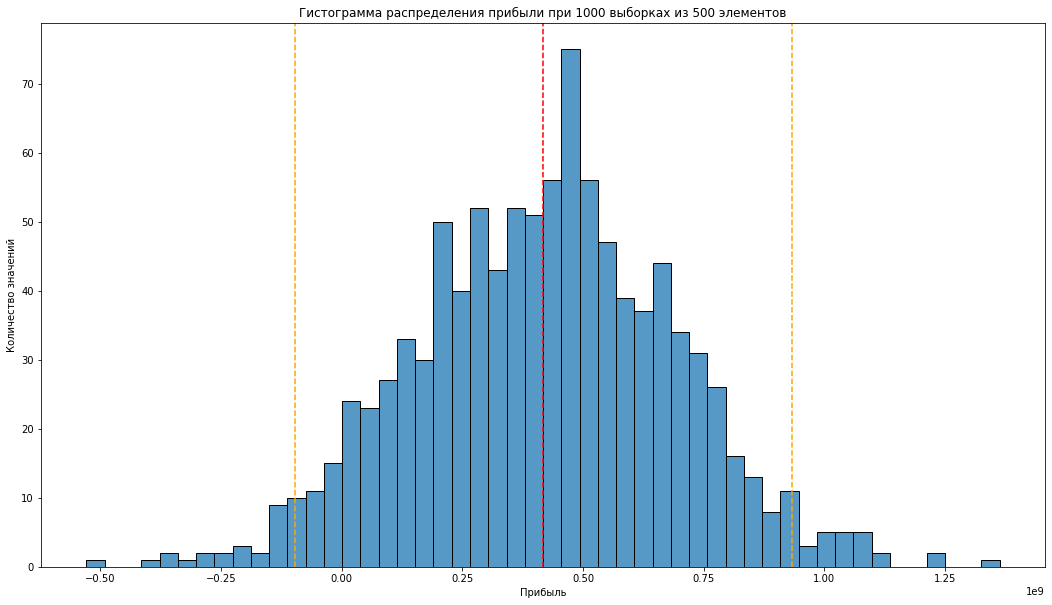

,Единицы измерения,Значение
Средняя прибыль,млн.руб.,417.354353
Доверительный интервал,млн.руб.,"(-96.26, 933.49)"
Риск,%,5.90%


In [59]:
hist_profit(geo_data_0)

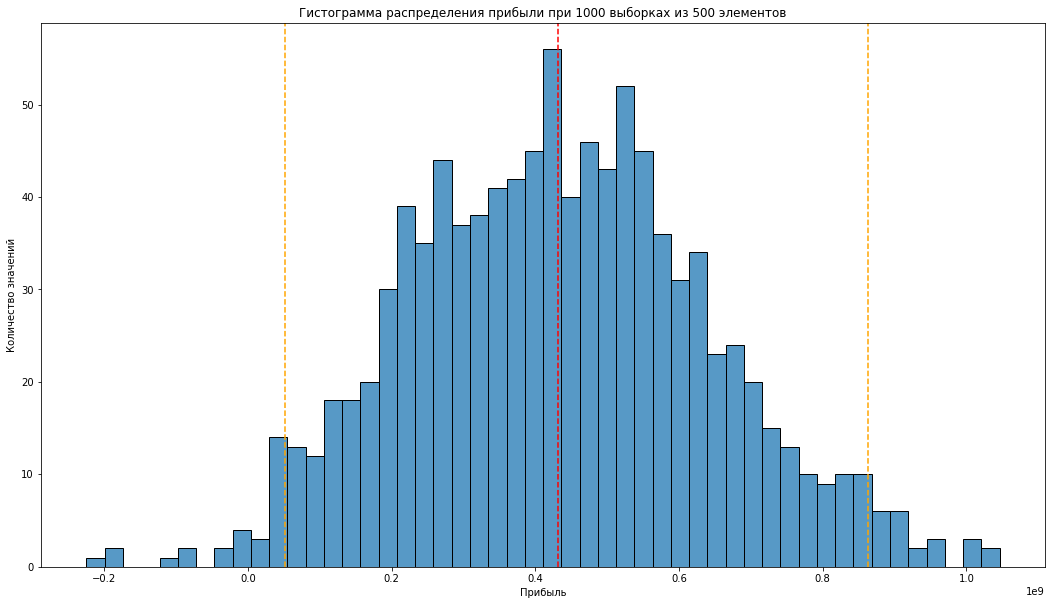

,Единицы измерения,Значение
Средняя прибыль,млн.руб.,432.01787
Доверительный интервал,млн.руб.,"(51.74, 863.04)"
Риск,%,1.00%


In [60]:
hist_profit(geo_data_1)

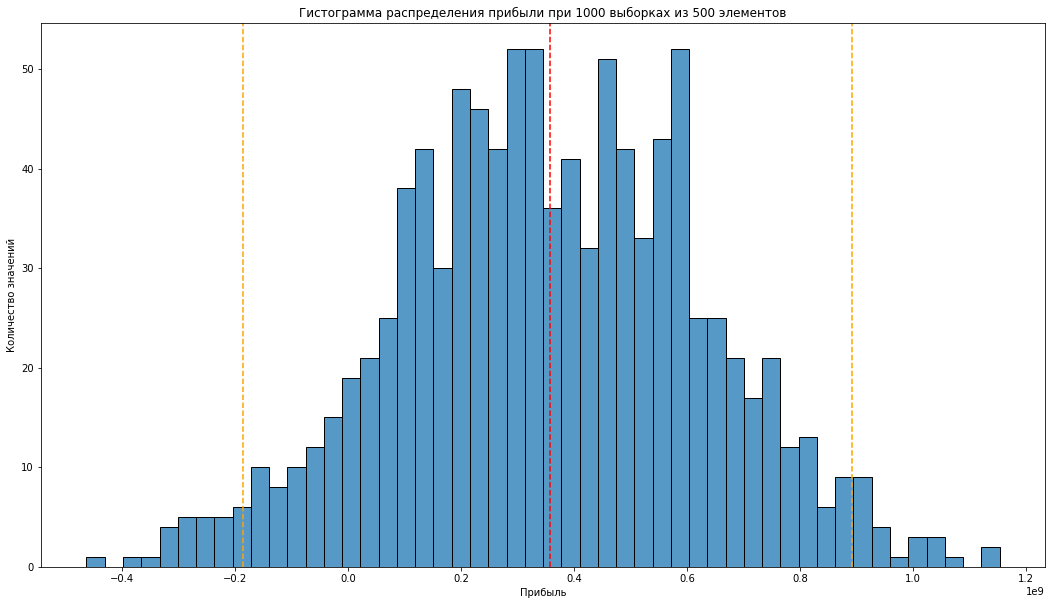

,Единицы измерения,Значение
Средняя прибыль,млн.руб.,356.881965
Доверительный интервал,млн.руб.,"(-186.26, 892.10)"
Риск,%,8.90%


In [61]:
hist_profit(geo_data_2)

**Вывод:**

При построении 1000 выборок установлено:

1. Средняя прибыль составила:
    - регион 0 - 417 млн.
    - регион 1 - 432 млн.
    - регион 2 - 356 млн.

2. Риск убытков:
    - регион 0 - 5.9%.
    - регион 1 - 1 %.
    - регион 2 - 8.9% 

## Общий вывод.

В ходе выполнения работы были выполнены следующие этапы: 

**1. Предобработка данных.**
    - Проведена загрузка данных и ознакомление с ними. Все три датафрейма состоят из 100 тыс. значений.
    - Названия столбцов соответствуют стандарту (змеиный регистр и латиница).
    - Типы данных соответствуют.
    - Удалены неявные дубликаты.
    - Пропусков не обнаружено.

**2. Исследовательский анализ.**
    - Проведен исследовательский анализ. Составлены графики.
    - В данных есть выбросы, однако неизвестна их природа.
    - В geo_data_2 входные признаки распределены нормально.
    - В geo_data_1 входной признак f2 похож на категориальный.
    
**3. Корреляционный анализ.**
    1. Для geo_data_0:
        - есть нелинейная корреляция между f0 и f1
    2. Для geo_data_1:
        - есть корреляция между f2 и product. Хорошая зависимость f2 с целевым признаком 
    3. Для geo_data_2:
        - есть корреляция между f2 и product .
    
4. Была построена модель машинного обучения, которая определяет объемы добычи на основе входных признаков f0 f1 f2 и служит для определения выгодного региона для бурения скважин. Анализ результатов работы модели показал следующее:
    - Наибольшая средняя добыча скважины у региона 2 - 94.935 единиц.
    - Наибольшая точность модели у региона 1. RMSE составил 0.89. Это подтверждается высокой корреляцией f2 и product в данном регионе.
    
4. Был рассчитан объём сырья для безубыточной разработки новой скважины.

    - Для покрытия убытков регион должен выдавать 22222.22 единиц нефти. 
    - При условии разработки 200 скважин, получается что одна скважина должна выдать не менее 111.11 единиц добычи. 
    - Во всех регионах средний объем добычи недостаточен для покрытия расходов на разработку скважины.
    - Определен объем сквавжин в каждом регионе с безубыточной разработкой:
        - Количество скважин безубыточной разработки в регионе 0 - 5301
        - Количество скважин безубыточной разработки в регионе 1 - 4570
        - Количество скважин безубыточной разработки в регионе 2 - 5225

5. Написана функция для подсчета прибыли и рассчитана предполагаемая прибыль в каждом из рассматриваемых регионов. 
    - Прибыль региона geo_data_0 - 34.685 млрд
    - Прибыль региона geo_data_1 - 24.151 млрд
    - Прибыль региона geo_data_2 - 23.966 млрд

6. С помощью техники Bootstrap при 1000 выборках построены графики распределение прибыли по регионам,а также поиск средней прибыли, 95%-й доверительного интервала и риска убытков. Информация следующая:
    - Средняя прибыль составила:
        - регион 0 - 417 млн.
        - регион 1 - 432 млн.
        - регион 2 - 356 млн.

    - Риск убытков:
        - регион 0 - 5.9%.
        - регион 1 - 1 %.
        - регион 2 - 8.9% 

**Итоги**

Наиболее перспективным регионом для бурения новых скважин считается **Регион 1**.

1. Качество модели: Модель, обученная на данных о пробах нефти этого региона, показала метрику RMSE - 0.89 - это лучший результат по сравнению с моделями, предсказывающими объемы сырья в других регионах. Это обусловлено высокой корреляцией входного признака f2 с целевым признаком.

2. Прибыльность и риск: Регион 1 показывает наибольшую среднюю прибыль среди всех регионов и является наименее рискованным по убыткам. Это делает его наиболее привлекательным вариантом для разработки новых месторождений. 

